# Importing libraries 
 import of all necessary libraries

In [ ]:
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, f1_score

import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
!pip install transformers

In [ ]:
from google.colab import drive 
drive.mount('gdrive')

In [ ]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/augmented_datafile.csv")
df.drop(["Unnamed: 0"],axis=1,inplace=True)

old_df = pd.read_csv("gdrive/My Drive/Colab Notebooks/old_datafile.csv")
old_df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.head()

,Categories,Titles,Texts,Keywords
0,Animals,animal attack,animal attacks are violent often fatal attacks...,violent bites aggressive attack public...
1,Animals,animal coloration,animal coloration is the general appearance of...,appearance coloured camouflage incidenta...
2,Animals,animal ethics,animal ethics is branch of ethics which examin...,rights welfare law human animal cognit...
3,Animals,animal husbandry,animal husbandry is the branch of agriculture ...,agriculture day to day care selective bree...
4,Animals,animal law,animal law is combination of statutory and cas...,statutory law rights violates policies...


# Text Augmentation 
*   Using the text summarization and Keybert techniques to generate additional samples.

* At least **10 new samples** are generated for each item in the original data set.

## Text Summarization

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization") 

In [ ]:
text ="""
AI has become a catchall term for applications that perform complex tasks that once required human input such as communicating with customers online or playing chess. The term is often used interchangeably with its subfields, which include machine learning and deep learning. There are differences, however. For example, machine learning is focused on building systems that learn or improve their performance based on the data they consume. It’s important to note that although all machine learning is AI, not all AI is machine learning.

To get the full value from AI, many companies are making significant investments in data science teams. Data science, an interdisciplinary field that uses scientific and other methods to extract value from data, combines skills from fields such as statistics and computer science with business knowledge to analyze data collected from multiple sources.
"""

In [ ]:
#text = " ".join(df["Texts"][4].split()[:600])
result = summarizer(text, min_length=40, max_length=70, do_sample=False)
summary = result[0]["summary_text"]
print(f'The length of the summarized text is {len(summary.split())} \n')
summary

The length of the summarized text is 51 



' AI has become a catchall term for applications that perform complex tasks that once required human input . The term is often used interchangeably with its subfields, which include machine learning and deep learning . Data science is an interdisciplinary field that uses scientific methods to extract value from data .'

The summary focuses primarily on the **first part** of the text, so we can see a significant similarity with this one compared to the full text.

From my point of view, I think that for each text, **the topic** is mainly presented in the first part.


In [ ]:
vectors = sbert_model.encode([summary,text,text[:1000]], convert_to_numpy=True)  
sim_vector = cosine_similarity(vectors,vectors)
print(f' Similarity between the summary and the full text {sim_vector[0][1]}')
print(f' Similarity between the summary and the first part of the text {sim_vector[0][2]}')

 Similarity between the summary and the full text 0.6378721594810486
 Similarity between the summary and the first part of the text 0.8806988596916199


In [ ]:
# this function takes more than 2hours for each text with 600 tokens (note: tested with more than 800 tokens but it didn't work 
#so we have to change the max length of the model which is 1024 tokens (based on it's vocablary))

def text_summarization(texts=df["Texts"]):
  """
  Input: The List of all texts in our dataframe
  Output: The list of summarized texts
  """
  summarized_texts = []
  #summarizer = pipeline("summarization")
  texts = texts.tolist()
  # summarizes each text in texts list
  summarized_texts = [summarizer( " ".join(text.split()[:600]) , min_length=60, max_length=70, do_sample=False)[0]["summary_text"]  for text in texts]    
    
    
  return summarized_texts

# Creat a new columns in df for the summaries
df["Summarized Texts"] = text_summarization()

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [ ]:
# delete the extra white space
df["Summarized Texts"] = df["Summarized Texts"].apply(lambda x : x.replace(" .","")) # eliminate the point at the end of each summary
df.to_csv("gdrive/My Drive/Colab Notebooks/new_datafile.csv")

## Data Augmentation

In [ ]:
!pip install textattack
!pip install tensorflow_text

In [ ]:
#import contractions
#from autocorrect import Speller
from tqdm import tqdm
from textattack.augmentation import EasyDataAugmenter

In [ ]:
def augmented_corpus(df=df):
  """
  Input: a dataframe that contains the texts and the keywords that we want to augment
  Ouput: lists of the augmented texts and keywords with the titles and categories 
  """
  categories,titles,texts,keywords = [],[],[],[] 
  n=0
  m=0
 # initialize the augmentation model that can generate up to 15 samples
  aug = EasyDataAugmenter(pct_words_to_swap=0.25, 
                        transformations_per_example=15)
  # Clean the list of keywords (which has been considered as a type of str with the brackets ect...)
  df["Keywords"] = df["Keywords"].apply(lambda x: re.sub('[^A-Za-z]'," ",str(x)).strip())

  for i in tqdm(range(len(df))):
    
      aug_text,aug_keys = [], []
      aug_text = aug.augment(df["Summarized Texts"][i])
      #Extract new keywords then do the augmentation
      key = kw_model_bert.extract_keywords(df["Texts"][i][:1000], keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10,stop_words='english')
      keys = [item[0] for item in key]
      new_keys = " ".join(keys)
      aug_keys = aug.augment(new_keys)
      
      n = len(aug_text)
      m=len(aug_keys)
      print(" The lengths n=",n,"and m=",m)

      texts.extend(aug_text)
      keywords.extend(aug_keys)
      

      if n>m : # if the list of texts larger than the lis of keywords then we should add n-m items to keywords
        k = n-m
        add_items = aug.augment(aug_keys[m-1]) # generate more items to add to keywords list
        keywords.extend(add_items[:k])
        categories.extend([df["Categories"][i]]*n) # if n=0 (in case of passing), there is no list to be added
        titles.extend([df['Titles'][i]]*n)

      elif n<m:
        k= m-n
        add_items = aug.augment(aug_text[n-1]) # generate more items to add to text list
        texts.extend(add_items[:k])
        categories.extend([df["Categories"][i]]*m) # if n=0 (in case of passing), there is no list to be added
        titles.extend([df['Titles'][i]]*m)
        
      else:
        categories.extend([df["Categories"][i]]*n) # if n=0 (in case of passing), there is no list to be added
        titles.extend([df['Titles'][i]]*n)

    

  return categories,titles,texts,keywords

categories,titles,texts,keywords = augmented_corpus()

In [ ]:
print(len(categories),len(titles),len(texts),len(keywords))

7008 7008 7008 7008


In [ ]:
old_df = df[['Categories','Titles','Texts','Keywords']]
new_df1 = pd.DataFrame({"Categories":categories,"Titles":titles,"Texts":texts,"Keywords":keywords})
new_df = pd.concat([[old_df,new_df1]])
len(new_df)

7592

In [ ]:
new_df.to_csv("gdrive/My Drive/Colab Notebooks/augmented_datafile.csv")

# Supervised Text Classification 



1.   Classification using LSTM after data augmentation because it's not pre-trained.
2.   Classification using bert before and after the data augmentation.
3.   Construction of a model combining the model that classifies from texts and the other that uses keywords.



## Building the models

### Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub
!pip install  tensorflow_text
import tensorflow_text as text

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM,Dropout

In [ ]:
# Encode the categories labels to numerical arguments
lb = LabelEncoder()
lb.fit(df['Categories'])
old_df['Target'] = lb.transform(old_df['Categories'])
df['Target'] = lb.transform(df['Categories'])
num_classes =  len(lb.classes_)

#lb.inverse_transform(df['Target']) gives the label assigned to each number

In [ ]:
# Process the list of keywords (which has been considered as a type of str)
df["Keywords"] = df["Keywords"].apply(lambda x: re.sub('[^A-Za-z]'," ",str(x)).strip())
old_df["Keywords"] = old_df["Keywords"].apply(lambda x: re.sub('[^A-Za-z]'," ",str(x)).strip())


# Splitting the data
Y = tf.keras.utils.to_categorical(df["Target"].values, num_classes=num_classes)
old_Y = tf.keras.utils.to_categorical(old_df["Target"].values, num_classes=num_classes)


def split_data(df,data,Y):
  return train_test_split(df[data], Y, test_size=0.2, random_state=110, stratify = Y)

X_train_old, X_test_old, Y_train_old, Y_test_old = split_data(old_df,'Texts',old_Y)
X_train, X_test, Y_train, Y_test = split_data(df,'Texts',Y)

x_train_old, x_test_old, y_train_old, y_test_old = split_data(old_df,'Keywords',old_Y)
x_train, x_test, y_train, y_test = split_data(df,'Keywords',Y)

In [ ]:
x_test.shape,y_test.shape

In [ ]:
# Observe the data if it's inbalanced of not
def plot_categories(df=df):
  plt.style.use('ggplot')
  num_classes = len(lb.classes_)
  colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
  iter_color = iter(colors)

  df["Categories"].value_counts().plot.barh(title="Reviews for each topic (n, %)", ylabel="Topics", color=colors, figsize=(7,7))

  for i, v in enumerate(df["Categories"].value_counts()):
    c = next(iter_color)
    plt.text(v, i,
            " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
            color=c, 
            va='center', 
            fontweight='bold')
    
plot_categories()    

In [ ]:
plot_categories(old_df)

In [ ]:
# Function aims to plot the accuracy of the model and it's evaluation on the test set
def plot_graphs(model, metric,title):
  plt.plot(model.history.history[metric],marker='o', markersize=4) # plots the metric used on train set
  plt.plot(model.history.history['val_'+metric], '',marker='x', markersize=5) # plots the metric used on test set
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.title(title,fontsize=10)
  plt.legend([metric, 'val_'+metric],loc='lower right',fontsize=10)
  plt.show()

### Building the models

#### LSTM model


In [ ]:
def LSTM_model(MAX_NB_WORDS, EMBEDDING_DIM,X):
  
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,  input_length=X.shape[1]))
  model.add(Dropout(0.2,name='dropout'))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(30, activation='softmax'))
  
  METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall')]


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy() ,
              metrics=METRICS)
  return model

#### Bert models

In [ ]:

def build_model():
  # Bert layers
  bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
  bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",trainable=True,name="Bert_encoder")

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)

  # Neural network layers
  L = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  L = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(L)

  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [L])

  METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall')]


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy() ,
              metrics=METRICS)

  return model

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)



In [ ]:
def build_model_combination():
  # Bert layers
  bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
  bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",trainable=True,name="Bert_encoder")

  # Neural network layers for texts classification
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_text')
  preprocessed_text = bert_preprocess(text_input)
  outputs_texts = bert_encoder(preprocessed_text)
  T = tf.keras.layers.Dropout(0.2, name="dropout_texts")(outputs_texts['pooled_output'])
  T = tf.keras.layers.Dense(num_classes, activation='softmax', name="output_texts")(T)


  # Neural network layers for keywords classification
  keywords_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input_keywords')
  preprocessed_keys = bert_preprocess(keywords_input)
  outputs_keys = bert_encoder(preprocessed_keys)
  K = tf.keras.layers.Dropout(0.2, name="dropout_keywords")(outputs_keys['pooled_output'])
  K = tf.keras.layers.Dense(num_classes, activation='softmax', name="output_keywords")(K)

  # Use inputs and outputs to construct a final model
  Average = tf.keras.layers.Average(name="Average_Layer")([T, K])
  model = tf.keras.Model(inputs=[text_input,keywords_input], outputs = [Average])

  METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall')]


  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy() ,
              metrics=METRICS)

  return model

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

## Testing LSTM Model on texts

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Texts'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 62715 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Texts'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (7592, 500)


In [ ]:
#Y = pd.get_dummies(df['Categories']).values
Y = tf.keras.utils.to_categorical(df["Target"].values, num_classes=num_classes)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (7592, 30)


In [ ]:
X_train_old, X_test_old, Y_train_old, Y_test_old = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train_old.shape,Y_train_old.shape)
print(X_test_old.shape,Y_test_old.shape)

(6832, 500) (6832, 30)
(760, 500) (760, 30)


In [ ]:
text_old_model = LSTM_model(MAX_NB_WORDS, EMBEDDING_DIM,X)

text_old_model.fit(X_train_old, Y_train_old,epochs=10,
           validation_data=(X_test_old,Y_test_old))

In [ ]:
plt.title('Accuracy')
plt.plot(text_old_model.history.history['accuracy'], label='train accuracy')
plt.plot(text_old_model.history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show();

##Classification without data augmentation

### Classification using Texts 

In [ ]:
#text_old_model = build_model()
#tf.keras.utils.plot_model(model=text_old_model, show_shapes=True, dpi=100)

In [ ]:
text_old_model = build_model()

text_old_model.fit(X_train_old, Y_train_old, 
           epochs=10,
           validation_data=(X_test_old,Y_test_old))

Epoch 1/10
15/15 [==============================] - 56s 2s/step - loss: 3.5719 - accuracy: 0.0514 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.2754 - val_accuracy: 0.0940 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 37s 3s/step - loss: 3.1263 - accuracy: 0.1049 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.9844 - val_accuracy: 0.1538 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 37s 2s/step - loss: 2.8185 - accuracy: 0.2548 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.6558 - val_accuracy: 0.3248 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 34s 2s/step - loss: 2.3354 - accuracy: 0.4582 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.2013 - val_accuracy: 0.5043 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 5/10
15/15 [==============================

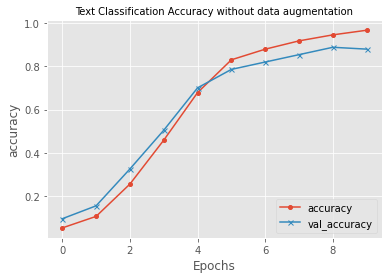

In [ ]:
plot_graphs(text_old_model, 'accuracy','Text Classification Accuracy without data augmentation')

In [ ]:
#text_old_model.save('gdrive/My Drive/Colab Notebooks/text_old_model.h5')
text_old_model = tf.keras.models.load_model(('gdrive/My Drive/Colab Notebooks/text_old_model.h5'),custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(text_old_model(X_test_old),axis=1)
y_true = np.argmax(Y_test_old,axis=1)
print(classification_report(y_true, y_pred, target_names=lb.classes_))
#print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

###Classification using keywords

In [ ]:
keywords_old_model = build_model()
keywords_old_model.fit(x_train_old, y_train_old, 
           epochs=10,
           validation_data=(x_test_old,y_test_old))

Epoch 1/10
15/15 [==============================] - 46s 2s/step - loss: 3.5432 - accuracy: 0.0471 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.3489 - val_accuracy: 0.0684 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 26s 2s/step - loss: 3.1923 - accuracy: 0.1006 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.1081 - val_accuracy: 0.1795 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 26s 2s/step - loss: 2.8983 - accuracy: 0.2313 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.7459 - val_accuracy: 0.3162 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 26s 2s/step - loss: 2.5295 - accuracy: 0.3919 - Precision: 1.0000 - Recall: 0.0021 - val_loss: 2.4489 - val_accuracy: 0.4615 - val_Precision: 1.0000 - val_Recall: 0.0085
Epoch 5/10
15/15 [==============================] - 26s 2s/step 

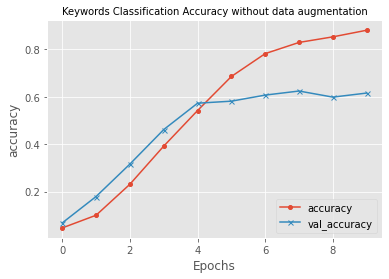

In [ ]:
plot_graphs(keywords_old_model, 'accuracy','Keywords Classification Accuracy without data augmentation') 

In [ ]:
#keywords_old_model.save('gdrive/My Drive/Colab Notebooks/keywords_old_model.h5')
keywords_old_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/keywords_old_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(keywords_old_model(X_test_old),axis=1)
y_true = np.argmax(Y_test_old,axis=1)
print(classification_report(y_true, y_pred, target_names=lb.classes_))
#print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

###Final Model with combinaision

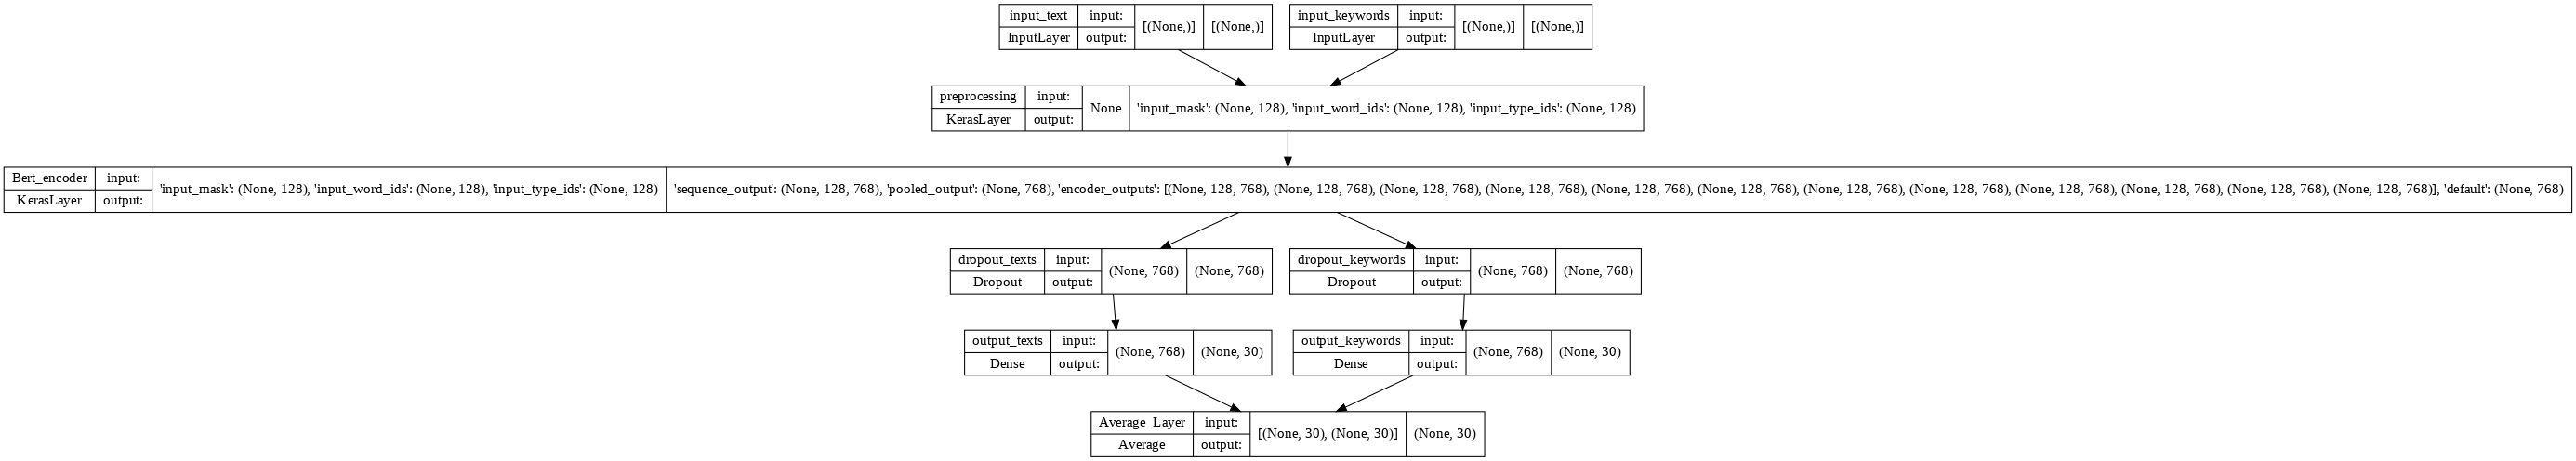

In [ ]:
final_old_model = build_model_combination()

tf.keras.utils.plot_model(model=final_old_model, show_shapes=True, dpi=76)

In [ ]:
final_old_model = build_model_combination()

# The training took more than 1hour
final_old_model.fit([X_train_old,x_train_old], Y_train_old, 
           epochs=10,
           batch_size=10,
           validation_data=([X_test_old,x_test_old],Y_test_old))

Epoch 1/10
47/47 [==============================] - 49s 643ms/step - loss: 3.4829 - accuracy: 0.0278 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 3.3446 - val_accuracy: 0.0684 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/10
47/47 [==============================] - 29s 620ms/step - loss: 3.0651 - accuracy: 0.2034 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 2.6281 - val_accuracy: 0.3846 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/10
47/47 [==============================] - 29s 616ms/step - loss: 2.2233 - accuracy: 0.5910 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - val_loss: 1.8296 - val_accuracy: 0.7436 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 4/10
47/47 [==============================] - 29s 614ms/step - loss: 1.4879 - accuracy: 0.8287 - Precision: 1.0000 - Recall: 0.0236 - val_loss: 1.3766 - val_accuracy: 0.8205 - val_Precision: 0.8333 - val_Recall: 0.0427
Epoch 5/10
47/47 [==============================] - 

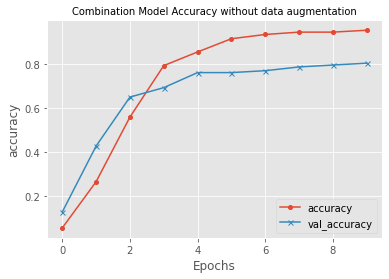

In [ ]:
plot_graphs(final_old_model,'accuracy','Combination Model Accuracy without data augmentation')

In [ ]:
#final_old_model.save('gdrive/My Drive/Colab Notebooks/final_old_model.h5')
final_old_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/final_old_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(final_old_model([X_test_old,x_test_old]),axis=1)
y_true = np.argmax(Y_test_old,axis=1)
print(classification_report(y_true, y_pred, target_names=lb.classes_))
#print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

## Classification using data augmentation

### Classification using Texts 


In [ ]:
text_model = build_model()

text_model.fit(X_train, Y_train, 
           epochs=10,
           validation_data=(X_test,Y_test))

Epoch 1/10
190/190 [==============================] - 194s 955ms/step - loss: 1.6202 - accuracy: 0.6340 - Precision: 0.9724 - Recall: 0.3540 - val_loss: 0.2400 - val_accuracy: 0.9618 - val_Precision: 0.9758 - val_Recall: 0.9282
Epoch 2/10
190/190 [==============================] - 180s 949ms/step - loss: 0.1637 - accuracy: 0.9676 - Precision: 0.9762 - Recall: 0.9541 - val_loss: 0.0635 - val_accuracy: 0.9868 - val_Precision: 0.9875 - val_Recall: 0.9855
Epoch 3/10
190/190 [==============================] - 180s 950ms/step - loss: 0.0644 - accuracy: 0.9835 - Precision: 0.9848 - Recall: 0.9821 - val_loss: 0.0395 - val_accuracy: 0.9875 - val_Precision: 0.9875 - val_Recall: 0.9875
Epoch 4/10
190/190 [==============================] - 180s 949ms/step - loss: 0.0463 - accuracy: 0.9849 - Precision: 0.9852 - Recall: 0.9845 - val_loss: 0.0410 - val_accuracy: 0.9842 - val_Precision: 0.9842 - val_Recall: 0.9835
Epoch 5/10
190/190 [==============================] - 180s 949ms/step - loss: 0.0364 - a

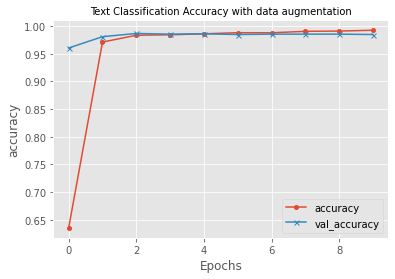

In [ ]:
plot_graphs(text_model, 'accuracy','Text Classification Accuracy with data augmentation')

In [ ]:
#text_model.save('gdrive/My Drive/Colab Notebooks/text_model.h5') 
text_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/text_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(text_model.predict(X_test),axis=1)
y_true = np.argmax(Y_test,axis=1)
print(classification_report(y_true, y_pred, target_names=lb.classes_))
#print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

In [ ]:
txt = text_cleaning("Marketing is the activity, set of institutions, and processes for creating, communicating, delivering, and exchanging offerings that have value for customers, clients, partners, and society at large.")

lb.inverse_transform(np.argmax(text_model.predict([txt])).reshape(1)) # Get the class name

array(['Marketing'], dtype=object)

###Classification using keywords

In [ ]:
keywords_model = build_model()

keywords_model.fit(x_train, y_train, 
           epochs=10,
           validation_data=(x_test,y_test))

Epoch 1/10
190/190 [==============================] - 365s 2s/step - loss: 1.5852 - accuracy: 0.6532 - Precision: 0.9679 - Recall: 0.3425 - val_loss: 0.3034 - val_accuracy: 0.9375 - val_Precision: 0.9610 - val_Recall: 0.9092
Epoch 2/10
190/190 [==============================] - 344s 2s/step - loss: 0.2190 - accuracy: 0.9564 - Precision: 0.9705 - Recall: 0.9359 - val_loss: 0.1294 - val_accuracy: 0.9671 - val_Precision: 0.9728 - val_Recall: 0.9638
Epoch 3/10
190/190 [==============================] - 343s 2s/step - loss: 0.1000 - accuracy: 0.9768 - Precision: 0.9814 - Recall: 0.9717 - val_loss: 0.1134 - val_accuracy: 0.9658 - val_Precision: 0.9741 - val_Recall: 0.9651
Epoch 4/10
190/190 [==============================] - 344s 2s/step - loss: 0.0667 - accuracy: 0.9789 - Precision: 0.9818 - Recall: 0.9776 - val_loss: 0.1191 - val_accuracy: 0.9691 - val_Precision: 0.9741 - val_Recall: 0.9658
Epoch 5/10
190/190 [==============================] - 344s 2s/step - loss: 0.0465 - accuracy: 0.9827

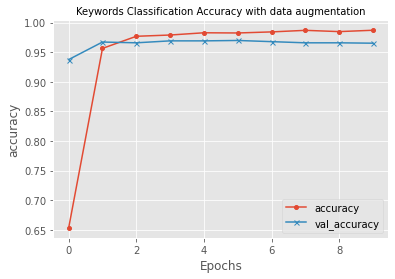

In [ ]:
plot_graphs(keywords_model, 'accuracy','Keywords Classification Accuracy with data augmentation') 

In [ ]:
#keywords_model.save('gdrive/My Drive/Colab Notebooks/keywords_model.h5')
keywords_model = tf.keras.models.load_model(('gdrive/My Drive/Colab Notebooks/keywords_model.h5'),custom_objects={'KerasLayer': hub.KerasLayer}) 

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(keywords_model.predict(x_test),axis=1)
y_true = np.argmax(y_test,axis=1)
print(classification_report(y_true, y_pred, target_names=lb.classes_))
#print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

###Final Model with combinaision

In [ ]:
# The training took more than 2hours
final_model = build_model_combination()

final_model.fit([X_train,x_train], Y_train, 
           epochs=10,
           batch_size=10,
           validation_data=([X_test,x_test],Y_test))

Epoch 1/10
608/608 [==============================] - 798s 1s/step - loss: 1.1656 - accuracy: 0.7766 - Precision: 0.9744 - Recall: 0.4380 - val_loss: 0.2041 - val_accuracy: 0.9598 - val_Precision: 0.9778 - val_Recall: 0.8999
Epoch 2/10
608/608 [==============================] - 744s 1s/step - loss: 0.1354 - accuracy: 0.9766 - Precision: 0.9861 - Recall: 0.9356 - val_loss: 0.0835 - val_accuracy: 0.9789 - val_Precision: 0.9925 - val_Recall: 0.9598
Epoch 3/10
608/608 [==============================] - 757s 1s/step - loss: 0.0610 - accuracy: 0.9844 - Precision: 0.9926 - Recall: 0.9699 - val_loss: 0.0497 - val_accuracy: 0.9776 - val_Precision: 0.9952 - val_Recall: 0.9598
Epoch 4/10
608/608 [==============================] - 748s 1s/step - loss: 0.0356 - accuracy: 0.9867 - Precision: 0.9948 - Recall: 0.9725 - val_loss: 0.0477 - val_accuracy: 0.9803 - val_Precision: 0.9899 - val_Recall: 0.9638
Epoch 5/10
608/608 [==============================] - 743s 1s/step - loss: 0.0489 - accuracy: 0.9816

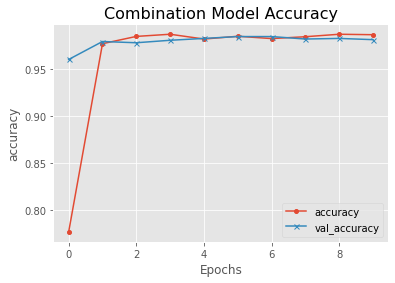

In [ ]:
plot_graphs(final_model,'accuracy','Combination Model Accuracy with data augmentation')

In [ ]:
#final_model.save('gdrive/My Drive/Colab Notebooks/final_model.h5')
final_model = tf.keras.models.load_model('gdrive/My Drive/Colab Notebooks/final_model.h5',custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
# Calculating the F1_score
y_pred = np.argmax(final_model.predict([X_test,x_test]),axis=1)
y_true = np.argmax(Y_test,axis=1)
print(classification_report(y_true, y_pred, target_names=lb.classes_))
#print("The F1_score is: ",f1_score(y_true, y_pred, average='weighted') ) # average = 'weighted' used in imbalanced data 

In [ ]:
txt="""AI has become a catchall term for applications that perform complex tasks that once required human input such as communicating with customers online or playing chess. The term is often used interchangeably with its subfields, which include machine learning and deep learning. There are differences, however. For example, machine learning is focused on building systems that learn or improve their performance based on the data they consume. It’s important to note that although all machine learning is AI, not all AI is machine learning.

To get the full value from AI, many companies are making significant investments in data science teams. Data science, an interdisciplinary field that uses scientific and other methods to extract value from data, combines skills from fields such as statistics and computer science with business knowledge to analyze data collected from multiple sources."""

In [ ]:
def text_cleaning(text):
    """
    text: text is string type to be cleaned.
    Function aims to clean the text from punctuation or special character, remove the stop words and lemmatizing the words.
   """

    
    text = text.lower()     
    text = re.sub("[^a-zA-Z]"," ",text)
    words = word_tokenize(text)
    words = [word for word in words if len(word)>=2 and not in set(stopwords.words('english'))] 

    return " ".join(words)

In [ ]:
key_txt = kw_model_bert.extract_keywords(txt, keyphrase_ngram_range=(1, 2), nr_candidates=15, top_n=10,stop_words='english')
k = str(list(dict(key_txt).keys()))

In [ ]:
prediction = final_model.predict([tf.convert_to_tensor([txt]) ,tf.convert_to_tensor([k]) ])

In [ ]:
np.any(prediction>0.6) # Tester si un des valeurs de classification est superieur à 0.5 (30 valeurs<=>30classes) 

False

In [ ]:
result = lb.inverse_transform(np.argmax(prediction).reshape(1)) # Get the class name
result[0] # That's why we need a threshold to detect if the topic belongs to our database or it's a new one

'School'